# Section 4.2 StrategyQA Classification with ModernBERT - LoRA Fine-tuning



## Setup and Imports

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset, DatasetDict, Dataset
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Load StrategyQA Dataset

In [2]:
ds = load_dataset("wics/strategy-qa", revision="refs/convert/parquet")
source = ds["test"]


questions = source['question']
answers = source['answer']
facts = source['facts']
decompositions = source['decomposition']
qids = source['qid']
terms = source['term']
descriptions = source['description']

answer_ints = [1 if ans else 0 for ans in answers]


train_indices, temp_indices = train_test_split(
    range(len(source)),
    test_size=0.20,
    random_state=42,
    stratify=answer_ints
)


temp_answer_ints = [answer_ints[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.50,
    random_state=42,
    stratify=temp_answer_ints
)


def create_dataset_from_indices(indices):
    return {
        'question': [questions[i] for i in indices],
        'answer': [answers[i] for i in indices],
        'facts': [facts[i] for i in indices],
        'decomposition': [decompositions[i] for i in indices],
        'qid': [qids[i] for i in indices],
        'term': [terms[i] for i in indices],
        'description': [descriptions[i] for i in indices]
    }

train_data = create_dataset_from_indices(train_indices)
val_data = create_dataset_from_indices(val_indices)
test_data = create_dataset_from_indices(test_indices)


from datasets import Dataset
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

dataset = DatasetDict(train=train_dataset, validation=val_dataset, test=test_dataset)


print(f"Training: {len(dataset['train'])} samples")
print(f"Validation: {len(dataset['validation'])} samples")
print(f"Testing: {len(dataset['test'])} samples")

max_length = 256

train_dataset = dataset['train']
val_dataset = dataset['validation']



0000.parquet:   0%|          | 0.00/720k [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training: 1832 samples
Validation: 229 samples
Testing: 229 samples


## Load ModernBERT Model and Tokenizer

In [3]:
model_name = "answerdotai/ModernBERT-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: answerdotai/ModernBERT-base
Model parameters: 149,606,402
Vocabulary size: 50,280


## Configure and Apply LoRA

In [4]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=1,
    lora_alpha=2,
    lora_dropout=0.1,
    target_modules=["model.layers.0.attn.Wo"],
    bias="none",
)

lora_model = get_peft_model(model, lora_config).to(device)

for name, param in lora_model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = False
lora_model.train()


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): ModernBertForSequenceClassification(
      (model): ModernBertModel(
        (embeddings): ModernBertEmbeddings(
          (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (layers): ModuleList(
          (0): ModernBertEncoderLayer(
            (attn_norm): Identity()
            (attn): ModernBertAttention(
              (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
              (rotary_emb): ModernBertRotaryEmbedding()
              (Wo): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_

## Create LoRA Classifier

In [5]:
classifier = lora_model.to(device)
classifier_trainable_params = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
total_classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"\nLoRA model trainable parameters: {classifier_trainable_params:,}")
print(f"LoRA model total parameters: {total_classifier_params:,}")
print(f"Training: {classifier_trainable_params/total_classifier_params*100:.1f}% of parameters")


LoRA model trainable parameters: 1,536
LoRA model total parameters: 149,609,476
Training: 0.0% of parameters


## Training Configuration

In [6]:
def collate_fn(batch):
    questions = [item['question'] for item in batch]
    answers = [item['answer'] for item in batch]
    facts = []
    for item in batch:
        facts.append(" ".join(s for s in item['facts'] if isinstance(s, str)))

    encoding = tokenizer(
        questions,
        facts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors='pt'
    )

    labels = []
    for answer in answers:
        if isinstance(answer, bool):
            label = 1 if answer else 0
        elif isinstance(answer, str):
            label = 1 if answer.lower() == 'yes' else 0
        else:
            label = 0
        labels.append(label)

    labels = torch.tensor(labels, dtype=torch.long).to(device)

    return {
        'input_ids': encoding['input_ids'].to(device),
        'attention_mask': encoding['attention_mask'].to(device),
        'label': labels
    }

BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
WARMUP_STEPS = 50
MAX_GRAD_NORM = 1.0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\nData loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

optimizer = optim.AdamW(classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)



Data loaders created:
Train batches: 115
Validation batches: 15







## Training Functions

In [7]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()


        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'Acc': f'{100 * correct / total:.2f}%'
        })

    return 100 * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

## LoRA Training Loop

In [8]:

train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}")

    train_acc = train_epoch(
        classifier, train_loader, optimizer, scheduler, criterion, device
    )

    val_acc = evaluate(
        classifier, val_loader, criterion, device
    )

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = classifier.state_dict().copy()
        print(f"New best validation accuracy: {best_val_acc:.2f}%")
        torch.save({
            'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'lora_config': lora_config,
        }, 'best_strategyqa_lora_classifier.pth')

print(f"Best validation accuracy: {best_val_acc:.2f}%")



Epoch 1


Evaluating: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Train Acc: 50.98%
Val Acc: 49.34%
New best validation accuracy: 49.34%

Epoch 2


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.95it/s]


Train Acc: 51.31%
Val Acc: 49.34%

Epoch 3


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.74it/s]


Train Acc: 50.98%
Val Acc: 50.22%
New best validation accuracy: 50.22%

Epoch 4


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.72it/s]


Train Acc: 51.42%
Val Acc: 50.22%

Epoch 5


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.11it/s]


Train Acc: 52.07%
Val Acc: 49.78%

Epoch 6


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.87it/s]


Train Acc: 52.40%
Val Acc: 48.91%

Epoch 7


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.40it/s]


Train Acc: 52.29%
Val Acc: 49.78%

Epoch 8


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.30it/s]


Train Acc: 52.62%
Val Acc: 49.34%

Epoch 9


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.96it/s]


Train Acc: 52.89%
Val Acc: 51.09%
New best validation accuracy: 51.09%

Epoch 10


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.26it/s]


Train Acc: 53.17%
Val Acc: 51.97%
New best validation accuracy: 51.97%

Epoch 11


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.10it/s]


Train Acc: 53.44%
Val Acc: 51.53%

Epoch 12


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.24it/s]


Train Acc: 53.98%
Val Acc: 50.66%

Epoch 13


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.80it/s]


Train Acc: 54.53%
Val Acc: 51.53%

Epoch 14


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.01it/s]


Train Acc: 54.80%
Val Acc: 51.97%

Epoch 15


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.38it/s]


Train Acc: 55.84%
Val Acc: 52.84%
New best validation accuracy: 52.84%

Epoch 16


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.31it/s]


Train Acc: 55.62%
Val Acc: 52.40%

Epoch 17


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.11it/s]


Train Acc: 56.33%
Val Acc: 51.97%

Epoch 18


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.04it/s]


Train Acc: 55.90%
Val Acc: 51.09%

Epoch 19


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.94it/s]


Train Acc: 56.88%
Val Acc: 52.84%

Epoch 20


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.15it/s]


Train Acc: 56.99%
Val Acc: 51.97%

Epoch 21


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.13it/s]


Train Acc: 57.21%
Val Acc: 52.40%

Epoch 22


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.94it/s]


Train Acc: 57.04%
Val Acc: 53.71%
New best validation accuracy: 53.71%

Epoch 23


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.20it/s]


Train Acc: 57.64%
Val Acc: 52.84%

Epoch 24


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.98it/s]


Train Acc: 57.26%
Val Acc: 53.71%

Epoch 25


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.18it/s]


Train Acc: 58.08%
Val Acc: 55.02%
New best validation accuracy: 55.02%

Epoch 26


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.98it/s]


Train Acc: 57.86%
Val Acc: 54.59%

Epoch 27


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.90it/s]


Train Acc: 58.08%
Val Acc: 53.28%

Epoch 28


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.10it/s]


Train Acc: 58.24%
Val Acc: 54.59%

Epoch 29


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.21it/s]


Train Acc: 58.95%
Val Acc: 54.15%

Epoch 30


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.27it/s]


Train Acc: 59.12%
Val Acc: 55.02%

Epoch 31


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.07it/s]


Train Acc: 58.73%
Val Acc: 55.46%
New best validation accuracy: 55.46%

Epoch 32


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.06it/s]


Train Acc: 59.12%
Val Acc: 55.90%
New best validation accuracy: 55.90%

Epoch 33


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.14it/s]


Train Acc: 59.22%
Val Acc: 56.33%
New best validation accuracy: 56.33%

Epoch 34


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.06it/s]


Train Acc: 59.12%
Val Acc: 55.02%

Epoch 35


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.99it/s]


Train Acc: 59.17%
Val Acc: 55.46%

Epoch 36


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.64it/s]


Train Acc: 59.22%
Val Acc: 55.90%

Epoch 37


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.25it/s]


Train Acc: 59.22%
Val Acc: 55.90%

Epoch 38


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.01it/s]


Train Acc: 59.55%
Val Acc: 55.90%

Epoch 39


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.02it/s]


Train Acc: 59.22%
Val Acc: 55.90%

Epoch 40


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.73it/s]


Train Acc: 59.88%
Val Acc: 56.77%
New best validation accuracy: 56.77%

Epoch 41


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.97it/s]


Train Acc: 59.33%
Val Acc: 55.46%

Epoch 42


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.48it/s]


Train Acc: 59.28%
Val Acc: 55.90%

Epoch 43


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.03it/s]


Train Acc: 59.12%
Val Acc: 55.02%

Epoch 44


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.91it/s]


Train Acc: 59.44%
Val Acc: 54.59%

Epoch 45


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.67it/s]


Train Acc: 59.33%
Val Acc: 55.02%

Epoch 46


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.37it/s]


Train Acc: 59.61%
Val Acc: 54.59%

Epoch 47


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.12it/s]


Train Acc: 59.33%
Val Acc: 55.46%

Epoch 48


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 33.34it/s]


Train Acc: 59.77%
Val Acc: 55.90%

Epoch 49


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.07it/s]


Train Acc: 59.77%
Val Acc: 55.90%

Epoch 50


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.20it/s]

Train Acc: 59.88%
Val Acc: 55.90%
Best validation accuracy: 56.77%


## Test Set Evaluation

In [9]:
if best_model_state is not None:
    classifier.load_state_dict(best_model_state)
else:

    checkpoint = torch.load('best_strategyqa_lora_classifier.pth', map_location=device)
    classifier.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.2f}%")


test_dataset = dataset['test']
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Test dataset: {len(test_dataset)} samples")
print(f"Test batches: {len(test_loader)}")


test_acc = evaluate(classifier, test_loader, criterion, device)


print("\n")
print("Final Result")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"LoRA Parameters: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")


Test dataset: 229 samples
Test batches: 15


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.57it/s]



Final Result
Test Accuracy: 51.53%
Best validation accuracy: 56.77%
Final training accuracy: 59.88%
Final validation accuracy: 55.90%
LoRA Parameters: 1,536


## Plot Result

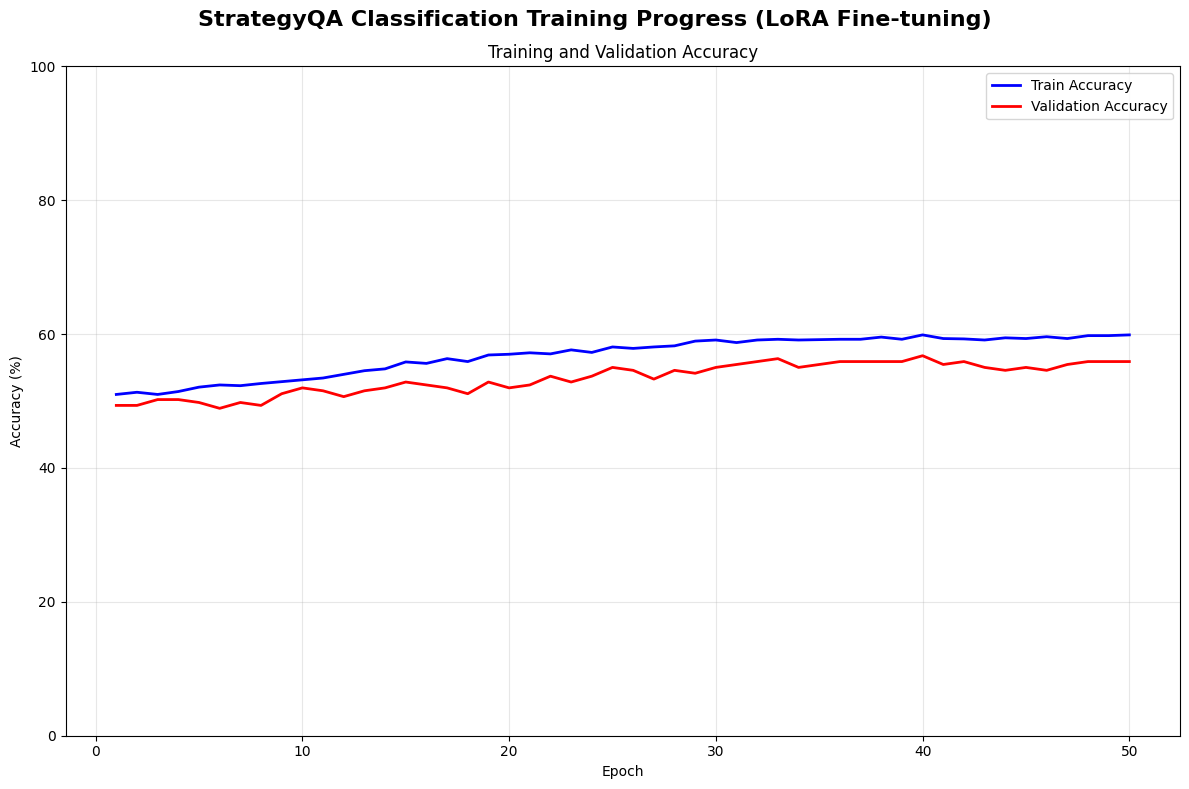

In [10]:

import matplotlib.pyplot as plt
import os


os.makedirs('results', exist_ok=True)


fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('StrategyQA Classification Training Progress (LoRA Fine-tuning)',
             fontsize=16, fontweight='bold')

epochs = range(1, len(train_accuracies) + 1)

ax.plot(epochs, train_accuracies, linewidth=2, markersize=6, label='Train Accuracy', color='blue')
ax.plot(epochs, val_accuracies, linewidth=2, markersize=6, label='Validation Accuracy', color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training and Validation Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

fig.tight_layout()


plot_path = 'results/strategyqa_lora_training.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()


## Download Plots


In [11]:

from google.colab import files


files.download('results/strategyqa_lora_training.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>